In [2]:
%load_ext watermark
%watermark

2018-01-01T19:33:09+01:00

CPython 3.6.1
IPython 6.2.1

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.10.0-42-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [20]:
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10, 10]
np.random.seed(42)

Recordemos el diagrama del proceso Data Science:

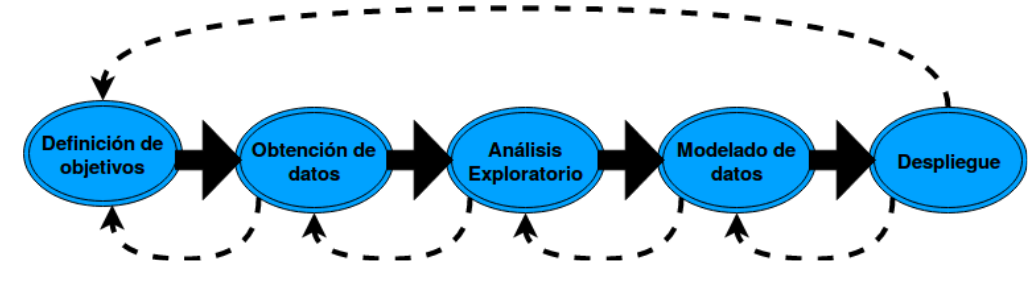

In [21]:
Image("../../media/proceso_datascience.png")

Hemos llegado a la última fase del Proceso de Data Science, la fase de despliegue. En esta fase es donde podemos usar los modelos que 

# Exportación de modelos.

El usar jupyter notebooks para entrenar y validar modelos es sólo el primer paso. Un aspecto importante de Data Science que la diferencia de por ejemplo, una persona trabajando en un laboratorio o un doctorado, es que en el proceso de Data Science se tiene en consecuencia el implementar los modelos predictivos en un entorno de producción, es decir, en un sistema que permita usar dichos modelos de forma automatizada y productiva.

Como ejemplo vamos a crear un sistema que permita evaluar precios de viviendas en base a sus características. Para ello vamos a usar el dataset Ames (que ya vimos en la sección de selección de variables.

In [22]:
ames = pd.read_csv("data/ames.csv").drop("id_parcela", axis=1)

In [23]:
ames.shape

(2930, 80)

In [24]:
ames.head()

,tipo_construccion,tipo_zona,perimetro_conectado_calle,area_parcela,tipo_acceso,tipo_acceso_trasero,forma_parcela,LandContour,tipo_instalaciones,config_parcela,...,area_piscina,calidad_piscina,calidad_valla,atributo_miscelaneo,valor_atributo_miscelaneo,mes_venta,ano_venta,tipo_venta,condicion_venta,precio_venta
0,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


Vamos a procesar el dataset de la misma forma que hicimos la vez anterior, sin embargo esta vez crearemos un pipeline de scikit-learn en vez de usar funciones de pandas para procesar las variables.

In [25]:
variables_independientes = ames.drop("precio_venta", axis=1).columns
variable_objetivo = ["precio_venta"]

In [26]:
datos_numericos = ames[variables_independientes].select_dtypes([int, float])
col_no_numericas = ames[variables_independientes].select_dtypes([object]).columns

col_numericas = datos_numericos.columns

# para crear este diccionario he ido a la descripcion del dataset
dict_var_ordinales = {
    "calidad_cocinas": ["Po", "Fa", "TA", "Gd", "Ex"],
    "funcionalidad":["Sal", "Sev", "Maj2", "Maj1", "Min2", "Min1","Typ"],
    "calidad_chimeneas":["NA","Po","Fa","TA","Gd","Ex"],
    "acabado_garaje":["NA","Unf","RFn","Fin"],
    "calidad_garaje":["NA","Po","Fa","TA","Gd","Ex"],
    "condicion_garaje":["NA","Po","Fa","TA","Gd","Ex"],
    "acceso_garaje_pavimentado":["N", "P", "Y"],
    "calidad_piscina":["NA","Fa","TA","Gd","Ex"],
    "calidad_valla":["NA","MnWw","GdWo","MnPrv","GdPrv"],
    "forma_parcela":["IR3", "IR2", "IR1","Reg"],
    "tipo_instalaciones":["ELO","NoSeWa","NoSewr","AllPub"],
    "pendiente_parcela":["Sev", "Mod", "Gtl"],
    "calidad_material_exterior":["Po","Fa","TA","Gd","Ex"],
    "condicion_material_exterior":["Po","Fa","TA","Gd","Ex"],
    "altura_sotano":["NA","Po","Fa","TA","Gd","Ex"],
    "condicion_sotano":["NA","Po","Fa","TA","Gd","Ex"],
    "sotano_exterior":["NA","No","Mn","Av","Gd"],
    "calidad_sotano_habitable1":["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "calidad_sotano_habitable2":["NA", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
     "calidad_calefaccion":["Po","Fa","TA","Gd","Ex"],
}
col_ordinales = list(dict_var_ordinales.keys())
datos_ordinales = ames[col_ordinales]
col_categoricas = list(set(col_no_numericas) - set(col_ordinales))
datos_categoricos = ames[col_categoricas]

Vamos a usar la extensión de scikit-learn [category encoders](http://contrib.scikit-learn.org/categorical-encoding/index.html) que tiene varias implementaciones de codificadores de variables categóricas que no existen en scikit-learn.

In [ ]:
import sys
!conda install -c conda-forge --yes --prefix {sys.prefix}  category_encoders

In [27]:
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

In [28]:
import category_encoders

Vamos a definir un transformador `ColumnExtractor` que puede tomar dataframes o listas de diccionarios y devolver una selección de columnas/claves

In [29]:
class ColumnExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, columns, output_type="matrix"):
        self.columns = columns
        self.output_type = output_type

    def transform(self, X, **transform_params):
        if isinstance(X, list):
            X = pd.DataFrame.from_dict(X)
        if self.output_type == "matrix":
            return X[self.columns].as_matrix()
        elif self.output_type == "dataframe":
            return X[self.columns]
        raise Exception("output_type tiene que ser matrix o dataframe")
        
    def fit(self, X, y=None, **fit_params):
        return self
        
    def fit(self, X, y=None, **fit_params):
        return self

Vamos a usar el transformador del paquete `category_encoders.OneHotEncoder` . A diferencia del `OneHotEncoder` nativo de scikit-learn, el de dicho paquete funciona con variables que son strings (por lo que no hay necesidad de codificarlas a variables numéricas anteriormente). Además, nos permite cierta flexibilidad si a la hora de usar el método transform aparece un valor de una variable que no existia en el dataset a la hora de ajustar. Pasándole el argumento `handle_unknown="impute"`, el codificador asignara un `-1` a valores desconocidos a la hora de transformar.

In [30]:
pipeline_categorico = Pipeline([
    ("selector_categorica", ColumnExtractor(
        columns=col_categoricas,
        output_type="dataframe")),
    ("transformador_categorico", category_encoders.OneHotEncoder(
        cols=col_categoricas, handle_unknown="impute")),
])

In [31]:
pipeline_categorico.fit(ames.head())
pipeline_categorico.transform(ames.head())

,tipo_zona_0,tipo_zona_1,tipo_zona_-1,LandContour_0,LandContour_-1,condicion_venta_0,condicion_venta_-1,config_parcela_0,config_parcela_1,config_parcela_-1,...,tipo_tejado_-1,cercania_carretera2_0,cercania_carretera2_-1,material_exterior2_0,material_exterior2_1,material_exterior2_2,material_exterior2_3,material_exterior2_-1,tipo_edificio_0,tipo_edificio_-1
0,1,0,0,1,0,1,0,1,0,0,...,0,1,0,1,0,0,0,0,1,0
1,0,1,0,1,0,1,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
2,1,0,0,1,0,1,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
3,1,0,0,1,0,1,0,1,0,0,...,0,1,0,0,0,0,1,0,1,0
4,1,0,0,1,0,1,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0


In [32]:
pipeline_numerico = Pipeline([
    ["selector_numerico", ColumnExtractor(columns=col_numericas)],
    ["transformador_numerico", Pipeline([
        ("imputador_numerico", Imputer()),
        ("escalador_numerico", StandardScaler())
    ])]
])

`category_encoders.OrdinalEncoders` requiere un mapeado específico para cada columna, indicando el número por el que queremos reemplazar cada nivel de cada variable ordinal. Si no especificamos un mapa, asume que el orden es aleatorio.

In [33]:
niveles_ordinales = []
for col, levels in dict_var_ordinales.items():
    niveles_ordinales.append({"col": col, 
                              "mapping": list(zip(levels, range(len(levels))))})
niveles_ordinales

[{'col': 'calidad_cocinas',
  'mapping': [('Po', 0), ('Fa', 1), ('TA', 2), ('Gd', 3), ('Ex', 4)]},
 {'col': 'funcionalidad',
  'mapping': [('Sal', 0),
   ('Sev', 1),
   ('Maj2', 2),
   ('Maj1', 3),
   ('Min2', 4),
   ('Min1', 5),
   ('Typ', 6)]},
 {'col': 'calidad_chimeneas',
  'mapping': [('NA', 0),
   ('Po', 1),
   ('Fa', 2),
   ('TA', 3),
   ('Gd', 4),
   ('Ex', 5)]},
 {'col': 'acabado_garaje',
  'mapping': [('NA', 0), ('Unf', 1), ('RFn', 2), ('Fin', 3)]},
 {'col': 'calidad_garaje',
  'mapping': [('NA', 0),
   ('Po', 1),
   ('Fa', 2),
   ('TA', 3),
   ('Gd', 4),
   ('Ex', 5)]},
 {'col': 'condicion_garaje',
  'mapping': [('NA', 0),
   ('Po', 1),
   ('Fa', 2),
   ('TA', 3),
   ('Gd', 4),
   ('Ex', 5)]},
 {'col': 'acceso_garaje_pavimentado',
  'mapping': [('N', 0), ('P', 1), ('Y', 2)]},
 {'col': 'calidad_piscina',
  'mapping': [('NA', 0), ('Fa', 1), ('TA', 2), ('Gd', 3), ('Ex', 4)]},
 {'col': 'calidad_valla',
  'mapping': [('NA', 0),
   ('MnWw', 1),
   ('GdWo', 2),
   ('MnPrv', 3),
   

In [34]:
pipeline_ordinal = Pipeline([
    ("selector_ordinal", ColumnExtractor(
        columns=col_ordinales, output_type="dataframe")),
    ("transformador_ordinal", category_encoders.ordinal.OrdinalEncoder(
        mapping=niveles_ordinales)),
])

In [35]:
pipeline_ordinal.fit_transform(ames.head()[col_ordinales])

,calidad_cocinas,funcionalidad,calidad_chimeneas,acabado_garaje,calidad_garaje,condicion_garaje,acceso_garaje_pavimentado,calidad_piscina,calidad_valla,forma_parcela,tipo_instalaciones,pendiente_parcela,calidad_material_exterior,condicion_material_exterior,altura_sotano,condicion_sotano,sotano_exterior,calidad_sotano_habitable1,calidad_sotano_habitable2,calidad_calefaccion
0,2,6,4,3,3,3,1,-1,-1,2,3,2,2,2,3,4,4,4,1,1
1,2,6,-1,1,3,3,2,-1,3,3,3,2,2,2,3,3,1,3,2,2
2,3,6,-1,1,3,3,2,-1,-1,2,3,2,2,2,3,3,1,5,1,2
3,4,6,3,3,3,3,2,-1,-1,3,3,2,3,2,3,3,1,5,1,4
4,2,6,3,3,3,3,2,-1,3,2,3,2,2,2,4,3,1,6,1,3


In [36]:
pipeline_procesado = FeatureUnion([
    ('variables_numericas', pipeline_numerico),
    ('variables_ordinales', pipeline_ordinal),
    ('variables_categoricas', pipeline_categorico),
])

In [37]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA, TruncatedSVD

In [38]:
pipeline_estimador = Pipeline([
    ("procesado_variables", pipeline_procesado),
    ("reducir_dim", PCA()),
    ("estimador", RandomForestRegressor())
])

In [39]:
pipeline_estimador.fit(X=ames, 
                y=ames[variable_objetivo])

/home/manuel/anaconda3/envs/data/lib/python3.6/site-packages/sklearn/pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)


Pipeline(memory=None,
     steps=[('procesado_variables', FeatureUnion(n_jobs=1,
       transformer_list=[('variables_numericas', Pipeline(memory=None,
     steps=[('selector_numerico', ColumnExtractor(columns=Index(['tipo_construccion', 'perimetro_conectado_calle', 'area_parcela',
       'calidad_general', 'condicion_general...timators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))])

In [40]:
pipeline_estimador.predict(X=ames.head())

array([ 231140. ,  110410. ,  169225. ,  232462.4,  189490. ])

Para saber como definir los parametros de cada elemento del pipeline para hacer un gridsearch, podemos usar `get_params`.

In [41]:
pipeline_estimador.get_params().keys()

dict_keys(['memory', 'steps', 'procesado_variables', 'reducir_dim', 'estimador', 'procesado_variables__n_jobs', 'procesado_variables__transformer_list', 'procesado_variables__transformer_weights', 'procesado_variables__variables_numericas', 'procesado_variables__variables_ordinales', 'procesado_variables__variables_categoricas', 'procesado_variables__variables_numericas__memory', 'procesado_variables__variables_numericas__steps', 'procesado_variables__variables_numericas__selector_numerico', 'procesado_variables__variables_numericas__transformador_numerico', 'procesado_variables__variables_numericas__selector_numerico__columns', 'procesado_variables__variables_numericas__selector_numerico__output_type', 'procesado_variables__variables_numericas__transformador_numerico__memory', 'procesado_variables__variables_numericas__transformador_numerico__steps', 'procesado_variables__variables_numericas__transformador_numerico__imputador_numerico', 'procesado_variables__variables_numericas__trans

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint

param_dist_random = {
    "estimador__max_depth": [3, None],
    "estimador__max_features": sp_randint(1, 11),
    "estimador__min_samples_split": sp_randint(2, 11),
    "estimador__min_samples_leaf": sp_randint(1, 11),
    "estimador__bootstrap": [True, False],
    "estimador__n_estimators": np.linspace(10,1000,10).astype(int),
    "estimador__min_impurity_decrease": np.logspace(-1, 0.0),
    "reducir_dim": [PCA(), TruncatedSVD()],
    "reducir_dim__n_components": sp_randint(10, 50)
}

busqueda_random = RandomizedSearchCV(
    estimator=pipeline_estimador, 
    param_distributions=param_dist_random, cv=5, refit=True,
    scoring="neg_mean_squared_error", n_jobs=-1,
    return_train_score=True,
    n_iter=100)

### Cómo deshabilitar warnings


Hay veces que no queremos ver warnings al ejecutar código, ya sea por que no sabemos lo que significan, o porque lo sabemos pero estamos en un bucle con lo cual dicho warning se va a repetir miles de veces.

Podemos deshabilitar un warning de forma permanente usando la función `filterwarnings` de la librería `warnings`

In [ ]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

Alternativamente, podemos filtrar warnings en el contexto de unas líneas de código en particular usando el siguiente código:

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    #todos los warnings que vayan en este contexto se deshabilitan
    busqueda_random.fit(X=ames.drop(variable_objetivo, axis=1),
                    y=ames[variable_objetivo])

In [50]:
busqueda_random.predict(ames.head())

array([ 215311.73913043,  105000.        ,  172121.73913043,
        243490.86956522,  189398.26521739])

In [54]:
busqueda_random.best_estimator_.steps

[('procesado_variables', FeatureUnion(n_jobs=1,
         transformer_list=[('variables_numericas', Pipeline(memory=None,
       steps=[('selector_numerico', ColumnExtractor(columns=Index(['tipo_construccion', 'perimetro_conectado_calle', 'area_parcela',
         'calidad_general', 'condicion_general', 'fecha_construccion',
         'ano_remodelado', 'area_reves...nvariant=False, handle_unknown='impute', impute_missing=True,
         return_df=True, verbose=0))]))],
         transformer_weights=None)),
 ('reducir_dim',
  PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)),
 ('estimador',
  RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=None,
             max_features=5, max_leaf_nodes=None,
             min_impurity_decrease=0.47148663634573934,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=230, n_jo

In [55]:
np.min(np.sqrt(np.abs(busqueda_random.cv_results_['mean_test_score'])))

27450.170094402492

Ya tenemos el pipeline, ahora podemos exportarlo

### Opción 1. Exportar con joblib

Tenemos que exportar 3 cosas para poder recrear el Pipeline:

**1. El pipeline entrenado.**

Podemos usar la libreria de scikit-learn `joblib` para guardar nuestro pipeline al disco duro. Joblib es una libreria basada en pickle que sirve para guardar objetos de python al disco duro, pero que está optimizado para scikit-learn.



In [56]:
from sklearn.externals import joblib

In [ ]:
joblib.dump(busqueda_random, 'pipeline_ames.pkl') 

De esta forma podemos cargar el modelo ya entrenado y predecir directamente

In [57]:
clf = joblib.load('pipeline_ames.pkl')

In [58]:
clf.predict(ames.head())

array([ 215311.73913043,  105000.        ,  172121.73913043,
        243490.86956522,  189398.26521739])

**2. Los nombres de las columnas**

Necesitamos saber las columnas que espera el pipeline para poder saber cómo tenemos que formatear los datos en el futuro de forma que los reconozca.

In [59]:
import json
with open('columnas_ames.json', 'w') as fname:
    ames_columnas = ames.columns.tolist()
    json.dump(ames_columnas, fname)

**3. Los tipos de datos de cada variable**

Necesitamos que las variables de las nuevas observaciones estén en el mismo formato que espera el pipeline.

In [60]:
ames_dtypes = ames.dtypes
ames_dtypes = {col: ames[col].dtype for col in ames.columns}
joblib.dump(ames_dtypes, 'dtypes_ames.pkl')

['dtypes_ames.pkl']

Ahora podemos crear un método para, dada una observación (que suponemos recibiremos como un diccionario de python) poder usarlo con nuestro pipeline.

In [62]:
nueva_observacion = ames.to_dict(orient="records")[0]
nueva_observacion

{'LandContour': 'Lvl',
 'acabado_garaje': 'Fin',
 'acceso_garaje_pavimentado': 'P',
 'aire_acondicionado_central': 'Y',
 'altura_sotano': 'TA',
 'ano_construccion_garaje': 1960.0,
 'ano_remodelado': 1960,
 'ano_venta': 2010,
 'area_garage': 528.0,
 'area_habitable_sobre_suelo': 1656,
 'area_parcela': 31770,
 'area_piscina': 0,
 'area_piso1': 1656,
 'area_piso2': 0,
 'area_porche_3estaciones': 0,
 'area_porche_abierto': 62,
 'area_porche_cerrado': 0,
 'area_porche_tapado': 0,
 'area_revestimiento': 112.0,
 'area_sotano_habitable1': 639.0,
 'area_sotano_habitable2': 0.0,
 'area_sotano_inhabitable': 441.0,
 'area_sotano_total': 1080.0,
 'area_suelos_baja_calidad': 0,
 'area_terraza_madera': 210,
 'atributo_miscelaneo': nan,
 'barrio': 'NAmes',
 'calidad_calefaccion': 'Fa',
 'calidad_chimeneas': 'Gd',
 'calidad_cocinas': 'TA',
 'calidad_garaje': 'TA',
 'calidad_general': 6,
 'calidad_material_exterior': 'TA',
 'calidad_piscina': nan,
 'calidad_sotano_habitable1': 'BLQ',
 'calidad_sotano_ha

In [63]:
obs = { 'precio_venta': 215000,
 'sistema_electrico': 'SBrkr',
 'sotano_exterior': 'Gd',
 'tipo_acceso': 'Pave',
 'tipo_andamios': 'CBlock',
 'tipo_calefaccion': 'GasA',
 'tipo_casa': '1Story',
 'tipo_construccion': 20,
 'tipo_edificio': '1Fam',
 'tipo_garaje': 'Attchd',
 'tipo_instalaciones': 'AllPub',
 'tipo_revestimiento': 'Stone',
 'tipo_tejado': 'Hip',
 'tipo_venta': 'WD ',
 'tipo_zona': 'RL',
 'valor_atributo_miscelaneo': 0}

In [65]:
def dict_a_df(obs, columnas, dtypes):
    obs_df = pd.DataFrame([obs])
    for col, dtype in dtypes.items():
        if col in obs_df.columns:
            obs_df[col] = obs_df[col].astype(dtype)
        else:
            obs_df[col] = None 
    return obs_df

obs_df = dict_a_df(obs, ames_columnas, ames_dtypes)
obs_df

,precio_venta,sistema_electrico,sotano_exterior,tipo_acceso,tipo_andamios,tipo_calefaccion,tipo_casa,tipo_construccion,tipo_edificio,tipo_garaje,...,area_porche_cerrado,area_porche_3estaciones,area_porche_tapado,area_piscina,calidad_piscina,calidad_valla,atributo_miscelaneo,mes_venta,ano_venta,condicion_venta
0,215000,SBrkr,Gd,Pave,CBlock,GasA,1Story,20,1Fam,Attchd,...,None,None,None,None,None,None,None,None,None,None


Ahora podemos predecir con el pipeline.

In [66]:
pipeline_estimador.predict(obs_df)

array([ 115930.])

Lo único que faltaria es crear una simple aplicación web (usando cualquier web framework, por ejemplo [Flask](http://flask.pocoo.org/) que cargue el modelo y permita aceptar peticiones con nuevas observaciones y devolver predicciones.

### Opción 2. Exportar a PMML

PMML **(Predictive Modelling Markup Language)** es un formato que intenta ser un estándar de modelado predictivo independiente de las plataformas en las que se entrenen los modelos.

Para scikit-learn existe el paquete [sklearn2pmml](https://github.com/jpmml/sklearn2pmml) que implementa una forma de exportar pipelines a pmml.

Sin embargo, pmml sólo soporta un fragmento de las opciones que tiene scikit-learn, y usarlo implica que no podemos usar transformadores creados por nosotros.

In [188]:
import sys
!{sys.executable} -m pip install git+https://github.com/jpmml/sklearn2pmml.git

  Cloning https://github.com/jpmml/sklearn2pmml.git to /tmp/pip-a7wyfbp8-build
  Running setup.py install for sklearn2pmml ... done


Vamos a ver el ejemplo sacado de la documentación de `sklearn2pmml`, para exportar a pmml un pipeline entrenado en el dataset Iris:

In [69]:
from sklearn.datasets import load_iris

In [70]:
iris = load_iris()
iris_df = pd.DataFrame(iris.data, columns=['Sepal.Length', 'Sepal.Width', 
                                           'Petal.Length','Petal.Width'])
iris_df["Species"] = iris.target

In [72]:
iris_df.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [73]:
from sklearn2pmml import PMMLPipeline
from sklearn2pmml.decoration import ContinuousDomain
from sklearn_pandas import DataFrameMapper
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.preprocessing import Imputer
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_iris


iris_pipeline = PMMLPipeline([
    ("mapper", DataFrameMapper([
    (["Sepal.Length", "Sepal.Width", "Petal.Length", "Petal.Width"], [ContinuousDomain(), Imputer()])
    ])),
    ("pca", PCA(n_components = 3)),
    ("selector", SelectKBest(k = 2)),
    ("classifier", LogisticRegression())
])
iris_pipeline.fit(iris_df, iris_df["Species"])

from sklearn2pmml import sklearn2pmml

sklearn2pmml(iris_pipeline, "LogisticRegressionIris.pmml", with_repr = True)

El formato pmml es un archivo xml donde se describe el pipeline.

In [74]:
!cat LogisticRegressionIris.pmml

<?xml version="1.0" encoding="UTF-8" standalone="yes"?>
<PMML xmlns="http://www.dmg.org/PMML-4_3" version="4.3">
	<Header>
		<Application name="JPMML-SkLearn" version="1.4.4"/>
		<Timestamp>2018-01-15T20:30:23Z</Timestamp>
	</Header>
	<MiningBuildTask>
		<Extension>PMMLPipeline(steps=[('mapper', DataFrameMapper(default=False, df_out=False,
        features=[(['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width'], [ContinuousDomain(), Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)])],
        input_df=False, sparse=False)),
       ('pca', PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)),
       ('selector', SelectKBest(k=2, score_func=&lt;function f_classif at 0x7f74f816dd90&gt;)),
       ('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random